Luke and Ray has shared the CRISPRi screening results which was analyzed with [ScreenProcessing](https://github.com/mhorlbeck/ScreenProcessing) pipeline. 

I've selected `ave_Rep1_Rep2` column for $\gamma$ and $\rho$ scores and put them into a two-column table to run iPAGE for phenotype encrichment analysis. 

- $\gamma$ - gamma score
- $\rho$ - rho score

0. Load screening result tables into python 
1. Make sure gene names are correctly assigned 
2. Exploring correlations, differences, and intersections among the screens.
3. Pathway enrichment analysis over the gamma and rho scores

In [1]:
import sys
import pandas as pd
import numpy as np 
from itertools import chain, product

import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
from venn import venn 


sys.path.append("../")
from util import *

In [2]:
data = load_data(screenings=True)

In [3]:
data.keys()

dict_keys(['molm13', 'hl60'])

In [4]:
data['hl60'].keys()

dict_keys(['exp1_DAC_rho', 'exp1_DAC_gamma', 'exp2_DAC_rho', 'exp2_DAC_gamma', 'exp2_GSK_rho', 'exp2_GSK_gamma'])

In [45]:
def drug_score_df(data, DRUG, SCORE):
    all_genes = [set(data[cell][key].index) for cell in data for key in data[cell] if DRUG in key and SCORE in key]
    genes = all_genes[0].intersection(all_genes[1]).intersection(all_genes[2])
    keys = ['_'.join([cell,key]) for cell in data for key in data[cell] if DRUG in key and SCORE in key]
    cols = [col[0]+col[1] for col in product(keys,[' score',' pvalue'])]
    all_df = [data[cell][key].loc[genes] for cell in data for key in data[cell] if DRUG in key and SCORE in key]
    df = pd.concat(all_df, axis=1).dropna().astype(float)
    df.columns = cols
    return df

# Pairwise correlations

Using `.iloc` induced the pandas into an object instead of dataframe, so `corr()` didn't work. Here is the solution: https://stackoverflow.com/questions/55251166/pandas-corr-returning

Then, using https://stackoverflow.com/questions/29432629/plot-correlation-matrix-using-pandas

### DAC $\gamma$-score

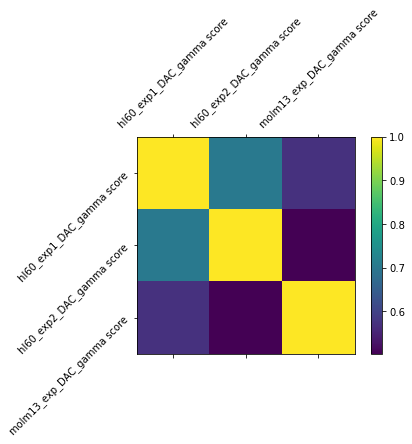

,hl60_exp1_DAC_gamma score,hl60_exp2_DAC_gamma score,molm13_exp_DAC_gamma score
hl60_exp1_DAC_gamma score,1.000000,0.702850,0.572527
hl60_exp2_DAC_gamma score,0.702850,1.000000,0.502196
molm13_exp_DAC_gamma score,0.572527,0.502196,1.000000


In [46]:
df = drug_score_df(data,'DAC','gamma').filter(like='score',axis=1)
plot_corr(df)
df.corr().style.background_gradient(cmap='coolwarm',axis=None)

### DAC $\rho$-score

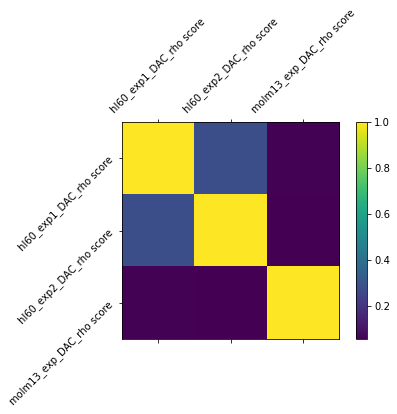

,hl60_exp1_DAC_rho score,hl60_exp2_DAC_rho score,molm13_exp_DAC_rho score
hl60_exp1_DAC_rho score,1.000000,0.282337,0.062309
hl60_exp2_DAC_rho score,0.282337,1.000000,0.056783
molm13_exp_DAC_rho score,0.062309,0.056783,1.000000


In [47]:
df = drug_score_df(data,'DAC','rho').filter(like='score',axis=1)
plot_corr(df)
df.corr().style.background_gradient(cmap='coolwarm',axis=None)

# Intersection

In [69]:
def intersection_analysis(SCORE,score_thr = 0.1,pvalue_thr = 0.05):

    raw_df = drug_score_df(data,'DAC',SCORE)
    exps = set([col.split(f'_{SCORE}')[0] for col in raw_df.columns.tolist()])

    dfs = [[e,raw_df.filter(like=e,axis=1)] for e in exps]

    results = []
    for exp in dfs:
        print(exp[0])
        results.append([exp[0]] + [find_top(
            exp[1],
            f'{exp[0]}_{SCORE} score', score_thr,
            f'{exp[0]}_{SCORE} pvalue', pvalue_thr
        )])

    studies = dict()
    for res in results:
        up,dn = res[1]
        studies[res[0]] = {}
        studies[res[0]]['up'] = set(up.index)
        studies[res[0]]['dn'] = set(dn.index)

    _, axs = subplots(ncols=2, nrows=1, figsize=(15, 5))

    venn(dict([[std,studies[std]['up']] for std in studies]),fontsize=10,legend_loc="upper left",ax=axs[0])
    axs[0].set_title(f"Up\n{SCORE} score >= {score_thr} &\n P-Value < {pvalue_thr}",fontsize=16)

    venn(dict([[std,studies[std]['dn']] for std in studies]),fontsize=10,legend_loc="upper left",ax=axs[1])
    axs[1].set_title(f"Down\n{SCORE} score <= {-1*score_thr} &\n P-Value < {pvalue_thr}",fontsize=16)

    plt.show()

In [63]:
# def find_hits(df, pvalue_thr = 0.05, score_thr = 0.1):
#     up = df.index[
#         (df.iloc[:,0] >= score_thr) &
#         (df.iloc[:,1] < pvalue_thr)
#     ]
#     dn = df.index[
#         (df.iloc[:,0] <= -1*score_thr) &
#         (df.iloc[:,1] < pvalue_thr)
#     ]
    
#     return up, dn

### DAC $\gamma$-score

hl60_exp1_DAC
up:  27
down: 1132
hl60_exp2_DAC
up:  366
down: 1601
molm13_exp_DAC
up:  168
down: 1933


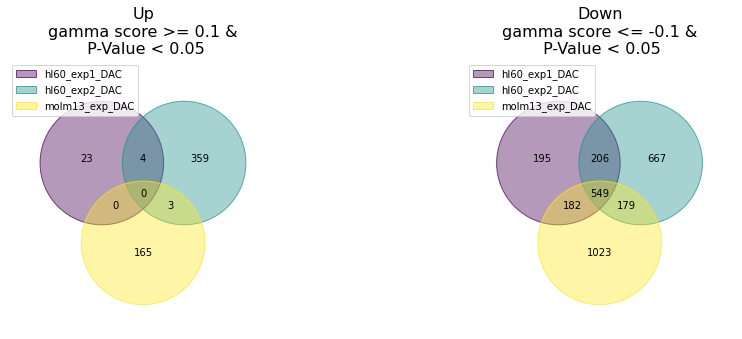

In [70]:
intersection_analysis('gamma')

### DAC $\rho$-score

hl60_exp1_DAC
up:  586
down: 691
hl60_exp2_DAC
up:  854
down: 592
molm13_exp_DAC
up:  719
down: 523


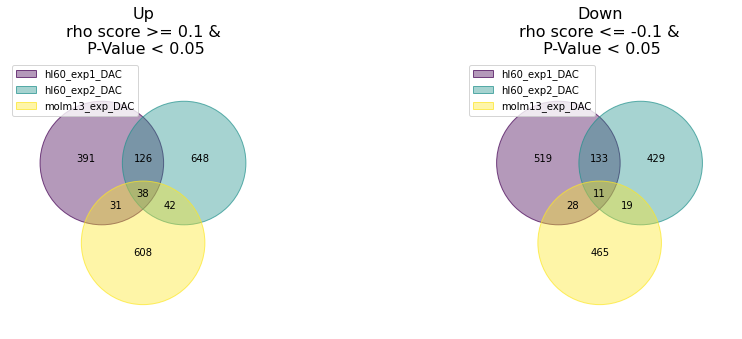

In [71]:
intersection_analysis('rho')

## m6A reader and writer genes 
[Table 1](https://www.nature.com/articles/s41419-017-0129-x/tables/1) at
> Dai, D., Wang, H., Zhu, L. et al. N6-methyladenosine links RNA metabolism to cancer progression. _Cell Death Dis_ **9**, 124 (2018). https://doi.org/10.1038/s41419-017-0129-x

In [4]:
df = drug_score_df(data,'DAC','rho')

table = pd.read_csv('../m6A-genes.tsv', sep = '\t')
table

NameError: name 'drug_score_df' is not defined

Clean and filter above table to take matched gene names for further analysis:

In [80]:
m6A_genes = table.Names.tolist()
RBMs = m6A_genes[4].split(' and its paralogue ')
m6A_genes.remove(m6A_genes[4])
m6A_genes = m6A_genes+RBMs
m6A_genes = [gene for gene in m6A_genes if gene in df.index.tolist()]

Add heatmap!

In [83]:
df.loc[m6A_genes]

,hl60_exp1_DAC_gamma score,hl60_exp1_DAC_gamma pvalue,hl60_exp2_DAC_gamma score,hl60_exp2_DAC_gamma pvalue,molm13_exp_DAC_gamma score,molm13_exp_DAC_gamma pvalue
gene_name,,,,,,
METTL3,-0.031227,0.174911,-0.073097,0.284670,-0.304481,0.007175
METTL14,0.021702,0.372033,-0.142152,0.039300,-0.181239,0.001130
WTAP,-0.004357,0.637314,-0.009656,0.765160,0.067994,0.417996
KIAA1429,-0.046617,0.007863,-0.113903,0.102633,-0.512569,0.073721
METTL16,-0.209788,0.022447,-0.106777,0.272272,-0.557533,0.002169
FTO,-0.029809,0.075161,0.047804,0.669931,-0.097296,0.042142
ALKBH5,-0.024058,0.521774,-0.028507,0.567372,0.036899,0.641141
YTHDC1,-0.082765,0.027462,-0.046976,0.173817,-0.358970,0.036083
YTHDF1,-0.008286,0.775219,-0.045124,0.340346,-0.010148,0.458709


## Phenotype-enrichment analysis
Run `iPAGE`:

In [ ]:
%%bash 
ipage=/rumi/shams/abe/Workflows/my_scripts/ipage_human_gene_name.sh
nohup ls CRISPRi_HL60_*.txt| \
parallel -j18 -k bash $ipage {} &> ipage.out

In [ ]:
# %reload_ext rpy2.ipython

In [ ]:
# %%R 
# library (ggplot2)

# plot_Save <- function (p, name_it){
#     ggsave(paste(name_it,'png',sep='.'), plot = p, device = 'png', dpi = 300)
#     ggsave(paste(name_it,'pdf',sep='.'), plot = p, device = 'pdf', dpi = 300)
# }


# plot_Hist = function(res, title, x_min=-0.5,x_max=0.5){
# #     w <- wilcox.test(res$logFC, mu=0, alternative = "greater")
# #     t <- t.test(res$logFC, mu=0, alternative = "greater")
#     h = ggplot(res, aes(x=logFC)) + 
#         ggtitle(title) +#,sprintf(
# #             "wilcox.test (-log10 p.value): %.5f \nt.test (-log10 p.value):%.5f \n[mu=0,alter=greater]", 
# #             -log10(w$p.value), -log10(t$p.value))) +
#         xlim(c(x_min,x_max)) +
#         geom_histogram(binwidth=0.001)

#     return (h)
# } 


In [ ]:
# %%R -i res
# plot_Hist(res, 'Rho score')